# Running TPCH 1 TB using Fabric DWH, SQL Endpoint and DuckDB

Data generated using rust : see  https://github.com/djouallah/Fabric_Notebooks_Demo/blob/main/TPCH/generate_data_tpch.ipynb

- Cost of ingestion to the DWH is not included

- Duckdb use a 64 node notebook, query 17 generated an OOM, it is used only as sanity check 

- for vorder, I used spark, basically create table x as select from table x_rust

In [13]:
pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.


In [14]:
import sempy.fabric  as fabric
import duckdb

In [15]:
SF            = 1000
result_path   = 'abfss://results@onelake.dfs.fabric.microsoft.com/data.Lakehouse/Tables/dbo/results'

In [16]:
pv = duckdb.sql(f"""
                        PIVOT (
                              select run, dur,sf,engine, query ,schema,  time , cpu from delta_scan('{result_path}') 
                              where test  ='tpch'  and sf = {SF}
                              )
                        ON run using avg(dur) order by query""")
xx = duckdb.sql("""
 select FORMAT('{:02d}', query) as query,time,sf,engine,schema ,cpu ,
  round(sum(COLUMNS(*exclude(query,sf,time,engine,schema,cpu))),1) from pv
  group by all order by  query
     """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [17]:
xxx = duckdb.sql(""" 
    SELECT
        sf,
        case when engine='duckdb' then 'duck' else lower(engine) end as ws,
        cpu as v_cores ,
        date_trunc('hour', time::TIMESTAMP AT TIME ZONE 'UTC' AT TIME ZONE 'Australia/Brisbane') AS time,
        schema ,
        ROUND(SUM(COLUMNS(*exclude(query, sf, time,engine,schema,cpu))) / 60, 1) AS "minutes_\\0",
        --ROUND(geomean(COLUMNS(*exclude(query, sf, time,engine,schema,cpu))), 1) AS "geomean_s_\\0",
        count(cold) AS "nbr_queries"
    FROM xx 
    GROUP BY ALL
    ORDER BY time DESC
""")

<mark>**Extract Compute Units for Compute and Onelake Transactions**</mark>

In [18]:
## basiclly i took the code from here : https://bradleyschacht.com/using-sempy-to-get-sql-query-cu-cost-from-the-fabric-capacity-metrics-app
capacity_metrics_workspace  = 'metric'
capacity_metrics_dataset    = 'Fabric Capacity Metrics'
capacity_id                 = '631FE32D-FE8B-4E9B-B6A5-61C35DD79FA7'
dax_command = f"""
	DEFINE
		MPARAMETER 'CapacityID' 	= "{capacity_id}"
		VAR __Var_CapacityId	= {{"{capacity_id}"}}
		VAR __Filter_CapacityId 	= TREATAS(__Var_CapacityId, 'Capacities'[capacityId])
        VAR __Filter_ws 	= TREATAS({{"duck","sqlendpoint","dwh"}}, 'Items'[WorkspaceName])
		VAR __DS0Core = 
			SUMMARIZECOLUMNS(
				'Items'[WorkspaceName] ,
				'DateTime'[Hour Start],'Items'[ItemKind],'Items'[ItemName],
				__Filter_CapacityId,   __Filter_ws ,
				"CUs", [Dynamic M1 CU Preview]
			)
	EVALUATE
		__DS0Core
	"""
df_dax = fabric.evaluate_dax(dax_string = dax_command, dataset = capacity_metrics_dataset, workspace = capacity_metrics_workspace)

In [19]:
cu = duckdb.sql("""
                    select
                    "Items[WorkspaceName]" as ws,
                    "Items[ItemKind]",
                    "Items[ItemName]" ,
                    "DateTime[Hour Start]" as hour, round(sum("[CUs]"),0) as CUs from df_dax
                    where
                    ("Items[ItemName]" ='warehouse' and "Items[WorkspaceName]" ='dwh' and "Items[ItemKind]" =  'Warehouse')
                    or ("Items[WorkspaceName]" ='duck' and ("Items[ItemName]" ='TPCH_duckdb' or "Items[ItemKind]" ='Lakehouse'))
                    or ( "Items[WorkspaceName]" ='sqlendpoint' and ( "Items[ItemKind]" =  'Lakehouse' or "Items[ItemKind]" =  'Warehouse'))
                    group by all
                    having CUs > 1
                    order by ws,hour,"Items[ItemName]"
               """)
cu.show(max_rows = 1000)

┌─────────────┬─────────────────┬─────────────────┬─────────────────────┬──────────┐
│     ws      │ Items[ItemKind] │ Items[ItemName] │        hour         │   CUs    │
│   varchar   │     varchar     │     varchar     │    timestamp_ns     │  double  │
├─────────────┼─────────────────┼─────────────────┼─────────────────────┼──────────┤
│ duck        │ SynapseNotebook │ TPCH_duckdb     │ 2025-05-23 21:00:00 │  30097.0 │
│ duck        │ Lakehouse       │ data            │ 2025-05-23 21:00:00 │    453.0 │
│ duck        │ SynapseNotebook │ TPCH_duckdb     │ 2025-05-24 00:00:00 │  31528.0 │
│ duck        │ Lakehouse       │ data            │ 2025-05-24 00:00:00 │    188.0 │
│ duck        │ SynapseNotebook │ TPCH_duckdb     │ 2025-05-24 14:00:00 │  31214.0 │
│ duck        │ Lakehouse       │ data            │ 2025-05-24 14:00:00 │    188.0 │
│ duck        │ SynapseNotebook │ TPCH_duckdb     │ 2025-05-24 21:00:00 │  29060.0 │
│ duck        │ Lakehouse       │ data            │ 2025-05-24 21

In [20]:
tt = duckdb.sql("""
    SELECT 
        xxx.* EXCLUDE (v_cores,schema),
        case when xxx.ws ='dwh' then 'vorder' when schema ='OP1000' then 'vorder' else 'rust' end as source,
        CUs,
        ROUND((CUs / 3600 )* 0.18, 3)                               AS total_cost,
        ROUND((minutes_cold + minutes_warm) , 3)                    AS dur,
        round((minutes_cold/dur) * total_cost ,3)                   AS cold_cost,
        round((minutes_warm/dur) * total_cost ,3)                   AS warm_cost
    FROM xxx
    JOIN ( select ws, hour , sum(CUs) as CUs from cu group by all ) as capacity 
        ON xxx.time = capacity.hour 
        AND xxx.ws = capacity.ws
    WHERE CUs > 0 
    ORDER BY time DESC
""")
tt.show(max_rows = 1000)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────┬─────────────┬─────────────────────┬──────────────┬──────────────┬─────────────┬─────────┬─────────┬────────────┬────────┬───────────┬───────────┐
│  sf   │     ws      │        time         │ minutes_cold │ minutes_warm │ nbr_queries │ source  │   CUs   │ total_cost │  dur   │ cold_cost │ warm_cost │
│ int64 │   varchar   │      timestamp      │    double    │    double    │    int64    │ varchar │ double  │   double   │ double │  double   │  double   │
├───────┼─────────────┼─────────────────────┼──────────────┼──────────────┼─────────────┼─────────┼─────────┼────────────┼────────┼───────────┼───────────┤
│  1000 │ sqlendpoint │ 2025-05-25 17:00:00 │          6.6 │          4.4 │          22 │ rust    │ 40720.0 │      2.036 │   11.0 │     1.222 │     0.814 │
│  1000 │ duck        │ 2025-05-25 17:00:00 │          7.8 │          5.6 │          21 │ vorder  │ 28322.0 │      1.416 │   13.4 │     0.824 │     0.592 │
│  1000 │ sqlendpoint │ 2025-05-25 15:00:00 │          6.4 │    

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

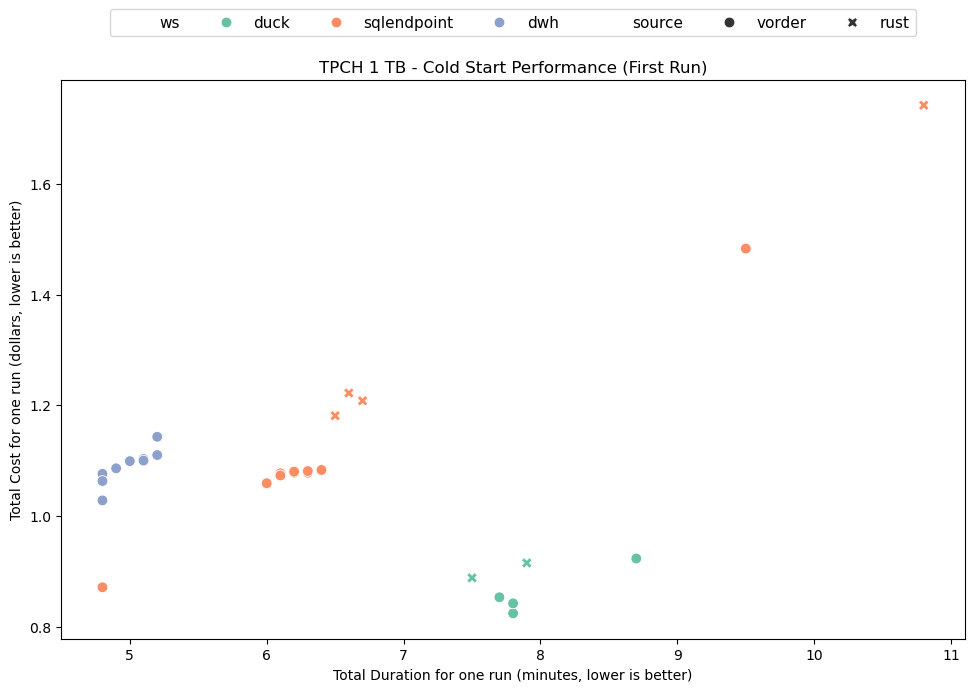

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = tt.df()

# --- Plot 1: Cold Start Performance ---
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df,
    x='minutes_cold',
    y='cold_cost',
    hue='ws',
    style='source',
    palette='Set2',
    s=60
)
plt.title('TPCH 1 TB - Cold Start Performance (First Run)')
plt.xlabel('Total Duration for one run (minutes, lower is better)')
plt.ylabel('Total Cost for one run (dollars, lower is better)')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.14),
    ncol=7,
    fontsize=11,
    title_fontsize=12
)
plt.tight_layout()
plt.show()

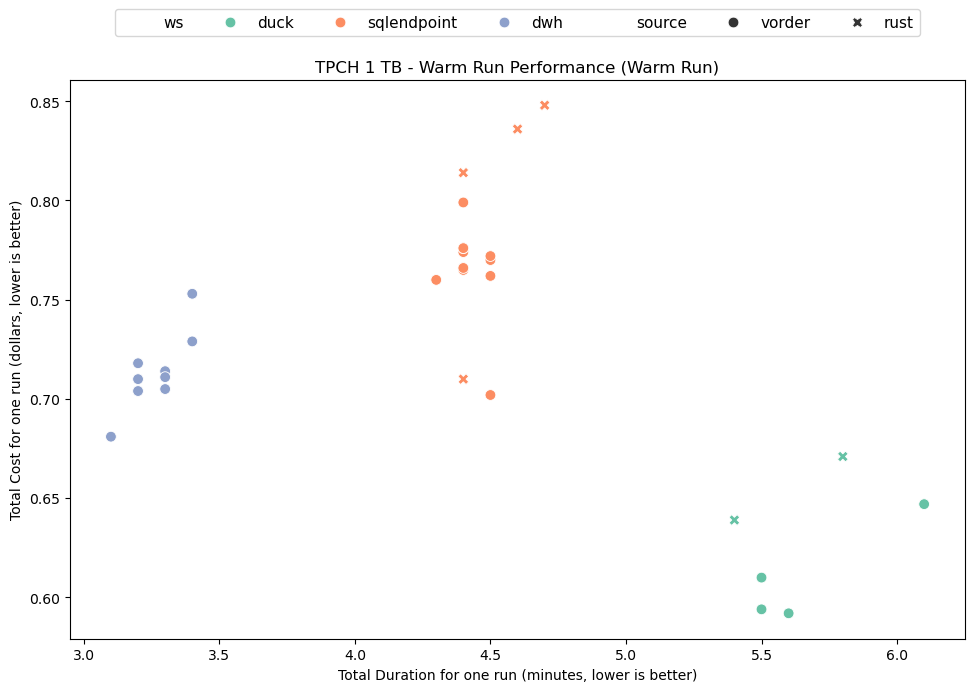

In [22]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df,
    x='minutes_warm',
    y='warm_cost',
    hue='ws',
    style='source',
    palette='Set2',
    s=60
)
plt.title('TPCH 1 TB - Warm Run Performance (Warm Run)')
plt.xlabel('Total Duration for one run (minutes, lower is better)')
plt.ylabel('Total Cost for one run (dollars, lower is better)')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.14),
    ncol=7,
    fontsize=11,
    title_fontsize=12
)
plt.tight_layout()
plt.show()